In [1]:
!conda env list

# conda environments:
#
base                     /home/gui/anaconda3
astronomy                /home/gui/anaconda3/envs/astronomy
iclinic                  /home/gui/anaconda3/envs/iclinic
kaggle                *  /home/gui/anaconda3/envs/kaggle
pong                     /home/gui/anaconda3/envs/pong
pyautogui                /home/gui/anaconda3/envs/pyautogui
pygame                   /home/gui/anaconda3/envs/pygame



# Importing libraries

In [26]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import time
from pprint import pprint
from collections import defaultdict


import warnings
warnings.filterwarnings('ignore')

# EDA

In [3]:
file = 'home-data-for-ml-course/train.csv'
df = pd.read_csv(file)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Metadata

In [4]:
from collections import defaultdict

meta = defaultdict(list)
for c in df.columns:
    meta[str(df[c].dtype)].append(c)

In [5]:
meta.keys()

dict_keys(['int64', 'object', 'float64'])

In [6]:
for k in meta.keys():
    print(df[meta[k]].info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 35 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
Fireplaces       1460 non-null int64
GarageCars       1460 non-null int64
Garag

1. 'int64' don't have nulls in train. If it have in test, input 0.
2. The nulls in 'object' are managed with the pd.get_dummies.
3. Input the 'float64' null values with 0. (It doesn't exist.)

# Preprocessing

## Null values in float64 and int 64 columns

In [7]:
for k in ['int64', 'float64']:
    for c in meta[k]:
        df.loc[df[c].isna(), c] = 0

In [8]:
df[meta['float64']].isna().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

## Categorical Values

In [9]:
df[meta['object']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
MSZoning         1460 non-null object
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1452 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 non-null object
BsmtQual         1423 non-null object
BsmtCond         1423 non-null object
BsmtExposure     1422

In [10]:
df[meta['object']].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


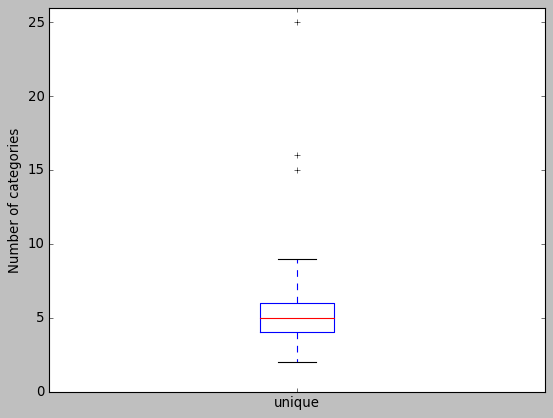

In [11]:
plt.style.use('classic')

df[meta['object']].describe().loc['unique', :].plot(kind='box')
plt.ylabel('Number of categories')
plt.ylim(0, 26)
plt.show()

Low number of categories, good to make dummy variables.

In [12]:
df = pd.get_dummies(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 290 entries, Id to SaleCondition_Partial
dtypes: float64(3), int64(35), uint8(252)
memory usage: 792.8 KB


In [52]:
def preprocessing(file, train=True):
    df = pd.read_csv(file)
    
    meta = defaultdict(list)
    for c in df.columns:
        meta[str(df[c].dtype)].append(c)
    for k in ['int64', 'float64']:
        for c in meta[k]:
            df.loc[df[c].isna(), c] = 0
    df = pd.get_dummies(df)
    
    ids_col = df.Id
    
    X = df.drop(['Id'], axis=1)
    if train:
        y = df.SalePrice
        X = X.drop('SalePrice', axis=1)
        return X, y
    else:
        return X, ids_col

# ML

In [14]:
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df.SalePrice

## Making a baseline

In [15]:
from sklearn.preprocessing import StandardScaler

In [31]:
file = 'home-data-for-ml-course/train.csv'
X, y = preprocessing(file)

params = {
    'objective': 'reg:linear'
}

# std_scaler = StandardScaler()
# X = std_scaler.fit_transform(X)

dtrain = xgb.DMatrix(X, y.values)


score = xgb.cv(params, dtrain, num_boost_round=100, early_stopping_rounds=10, metrics='rmse')

In [32]:
score.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
29,5904.646647,94.471553,29155.312500,1973.329204
30,5724.078613,101.850264,29167.847005,1980.963850
31,5573.929036,82.542101,29175.516276,2008.107857
32,5432.939453,112.810875,29186.300781,2017.159598
33,5304.552897,64.122664,29148.608073,2049.078292


overfitted?

## Tunning L1

In [57]:
def make_pipeline():
    std_scaler = StandardScaler()
    xbm_reg = xgb.XGBRegressor()

    steps = [
        ('scaler', std_scaler),
        ('model', xbm_reg)
    ]

    gbm_param_grid = {
        'model__reg_alpha': [1e-5, 1e-2, 0.1, 1, 100], # np.arange(100), #
        'model__eval_metric': ['rmse'],
    }


    pipe = Pipeline(steps)

    grid = GridSearchCV(pipe, gbm_param_grid, scoring='neg_mean_squared_error', cv=4, verbose=0, 
                                      n_jobs=-1, iid=False, return_train_score=True)
    return grid

In [58]:
file = 'home-data-for-ml-course/train.csv'
X, y = preprocessing(file)

score = make_pipeline()

score.fit(X, y)

print('Best score:', np.sqrt(abs(score.best_score_)))
print('Best parameters:', score.best_params_)

df_scores = np.sqrt(abs(pd.DataFrame(score.cv_results_).loc[:, ['mean_train_score', 'mean_test_score']]))

df_scores

Best score: 28280.627853490616
Best parameters: {'model__eval_metric': 'rmse', 'model__reg_alpha': 1e-05}


,mean_train_score,mean_test_score
0,14257.734127,28280.627853
1,14257.734382,28280.627954
2,14257.735715,28280.628144
3,14257.750995,28280.635895
4,14247.137003,28300.403185


## Pipeline

In [54]:
# train file
file = 'home-data-for-ml-course/train.csv'
X_train, y_train = preprocessing(file)

In [67]:
# test file
file = 'home-data-for-ml-course/test.csv'
X_test, ids_col = preprocessing(file, train=False)

In [66]:
X_train = X_train.loc[:, X_test.columns]

In [68]:
grid = make_pipeline()

In [69]:
grid.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, m... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))]),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'model__reg_alpha': [1e-05, 0.01, 0.1, 1, 100], 'model__eval_metric': ['rmse']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [73]:
y_pred = grid.predict(X_test)

In [76]:
# make submission file
df_subm = pd.DataFrame({'Id': ids_col, 'SalePrice': y_pred})
nonce = round(time.time() * 1000) # time in msec
df_subm.to_csv('submissions/subm_{}.csv'.format(nonce), index=False)

# Submitting and updating Git

In [80]:
# https://github.com/Kaggle/kaggle-api
# import kaggle
# !kaggle competitions list

# have to write the name of the file mannually
!kaggle competitions submit house-prices-advanced-regression-techniques -f submissions/subm_1556821577622.csv -m 'Baseline'
# !git add titanic.ipynb
# !git commit -m 'dev/kaggle/kaggle_titanic/titanic/submissions/subm_1556792572215.csv'
# !git push origin master

100%|██████████████████████████████████████| 21.2k/21.2k [00:03<00:00, 6.14kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques

In [1]:
!git status

No ramo master
Your branch is up to date with 'origin/master'.

Arquivos não monitorados:
  (utilize "git add <arquivo>..." para incluir o que será submetido)

	Housing_Prices_Competition.ipynb
	home-data-for-ml-course/
	old/
	submissions/

nada adicionado ao envio mas arquivos não registrados estão presentes (use "git add" to registrar)
